In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from scipy import constants 
%matplotlib inline

In [29]:
# Parametersfor the benchmarking
fps=100
num_particles=100
dt=1.0/fps
spatial_resolution=1.0E-8  # in metres per px
dust_diameter=7.14E-6 # in metres
dust_rho=1510.0
mu = 0
mass = 4.0 / 3.0 * np.pi * ( dust_diameter/ 2.0)**3 * dust_rho #mass of the dust particles
# print(mass)
kb=constants.Boltzmann
TeV=0.1
T= TeV*constants.e/kb #temperature in Kelvin (0.13 eV converted to Kelvin))
print(T)
sigma = np.sqrt(kb*T/mass)
print(sigma)

left=0
right=1751 # right border in px as per the camera of expt
up=400 # up border in px as per the camera of expt
down=0
left_SI=left*spatial_resolution
right_SI=right*spatial_resolution
up_SI=up*spatial_resolution
down_SI=down*spatial_resolution
final_frame=2
n_bins=19

1160.4518121550082
0.00023595006124153709


In [30]:
def make_velocities(fps,num_particles,spatial_resolution, mu,T, right_border_px, up_border_px,final_frame):
    dt=1.0/fps
    init_frame=1
    dust_diameter=7.14E-6 
    dust_rho=1510.0
    mass = 4.0 / 3.0 * np.pi * (dust_diameter/ 2.0)**3 * dust_rho #mass of the dust particles
    # print(mass)
    kb=constants.Boltzmann
    sigma = np.sqrt(kb*T/mass)
    # print(sigma)
    left=0
    down=0
    down_SI=down*spatial_resolution
    left_SI=left*spatial_resolution
    up_SI=up_border_px*spatial_resolution
    right_SI=right_border_px*spatial_resolution
    frame_full_df=pd.DataFrame()
    while init_frame<=final_frame:
        if init_frame==1:
            # Generate a sample of 1000 random numbers from a uniform distribution to act as the x coordinates of the particles
            unif_x = sts.uniform(left_SI, right_SI-left_SI)
            sample_x=unif_x.rvs(num_particles)
            sample_x_in_resol= sample_x/spatial_resolution
            sample_x_trunc= sample_x_in_resol.astype('int64')
            sample_x_trunc_SI=sample_x_trunc.astype('float64')*spatial_resolution
            
            unif_y = sts.uniform(down_SI, up_SI-down_SI)
            sample_y=unif_y.rvs(num_particles)
            sample_y_in_resol= sample_y/spatial_resolution
            sample_y_trunc= sample_y_in_resol.astype('int64')
            sample_y_trunc_SI=sample_y_trunc.astype('float64')*spatial_resolution

            part_no = np.arange(0,num_particles,dtype = 'int') # array of particles ID numbers
            # Generate a sample of 1000 random velocities from a normal distribution
            norm_rv = sts.norm(mu, sigma)
            sample_vx = norm_rv.rvs(num_particles) #generate a sample of certain size
            sample_vy = norm_rv.rvs(num_particles) #generate a sample of certain size
            
        # Simulating the motion of the particles for x coordinates
        x_forward = sample_x_trunc_SI + sample_vx*dt
        x_forward_in_resol = x_forward / spatial_resolution
        x_forward_trunc = x_forward_in_resol.astype('int64')
        x_forward_SI = x_forward_trunc.astype('float64') * spatial_resolution
        # Simulating the motion of the particles for y coordinates
        y_forward = sample_y_trunc_SI + sample_vy * dt
        y_forward_in_resol = y_forward / spatial_resolution
        y_forward_trunc = y_forward_in_resol.astype('int64')
        y_forward_SI=y_forward_trunc.astype('float64')*spatial_resolution

        # Calculating restored velocities
        v_restored_x=(x_forward_SI- sample_x_trunc_SI)/dt
        v_restored_y=(y_forward_SI- sample_y_trunc_SI)/dt
        # Append the data for the current frame
        frame_data={'part_no':part_no, 'x': sample_x_trunc_SI, 'y':sample_y_trunc_SI, 'frame': init_frame,'vx (restored)': v_restored_x, 'vy (restored)': v_restored_y, 'vx': sample_vx, 'vy': sample_vy}
        frame_df=pd.DataFrame(frame_data)
        frame_full_df = pd.concat([frame_full_df, frame_df], ignore_index=True)
        sample_x_trunc_SI=x_forward_SI
        sample_y_trunc_SI= y_forward_SI
        init_frame+=1
    return frame_full_df

In [31]:
def get_percent_discrepancies(v_restored,v_actual):
    discrepancy = np.abs(v_actual - v_restored)
    # print(np.mean(discrepancy))
    frac_discrepancy = np.abs(discrepancy / v_actual)
    # print(np.mean(frac_discrepancy))
    percent_discrepancy = frac_discrepancy*100
    # print(np.mean(percent_discrepancy))
    return np.mean(percent_discrepancy)

In [32]:
spatial_resolution_arr=np.arange(1E-6,40E-6,0.25E-6)
# print(spatial_resolution_arr)
print(len(spatial_resolution_arr))


157


In [33]:
discrepancy_arr=[]
T_discrepancy_arr=[]
for i in range(len(spatial_resolution_arr)):
    spatial_resolution_loop=spatial_resolution_arr[i]
    df=make_velocities(100,num_particles,spatial_resolution_loop, mu,T, right, up,2)
    discrepancy=get_percent_discrepancies(df[df['frame']==1]['vx (restored)'],df[df['frame']==1]['vx'])
    discrepancy_arr.append(discrepancy)
    T_restored=mass*np.std(df[df['frame']==1]['vx (restored)'])**2/constants.Boltzmann
    T_discrepancy_arr.append(np.abs(T-T_restored)/T)

Text(0, 0.5, 'Fractional discrepancy')

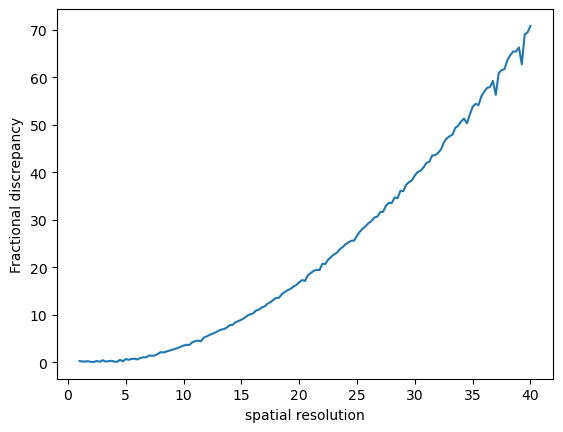

In [34]:
fig, ax = plt.subplots()
ax.plot(spatial_resolution_arr*1000000, T_discrepancy_arr)
ax.set_xlabel('spatial resolution')
ax.set_ylabel('Fractional discrepancy')
# ax.set_xscale('log')

In [35]:
fps_arr = np.arange(30.0, 305.0,2.0)
# print(fps_arr)
print(len(fps_arr))

138


In [36]:
discrepancy_arr=[]
T_discrepancy_arr=[]
for i in range(len(fps_arr)):
    fps_loop=fps_arr[i]
    df=make_velocities(fps_loop,num_particles,spatial_resolution, mu,T, right, up,2)
    discrepancy=get_percent_discrepancies(df[df['frame']==1]['vx (restored)'],df[df['frame']==1]['vx'])
    discrepancy_arr.append(discrepancy)
    T_restored=mass*np.std(df[df['frame']==1]['vx (restored)'])**2/constants.Boltzmann
    T_discrepancy_arr.append(np.abs(T-T_restored)/T)

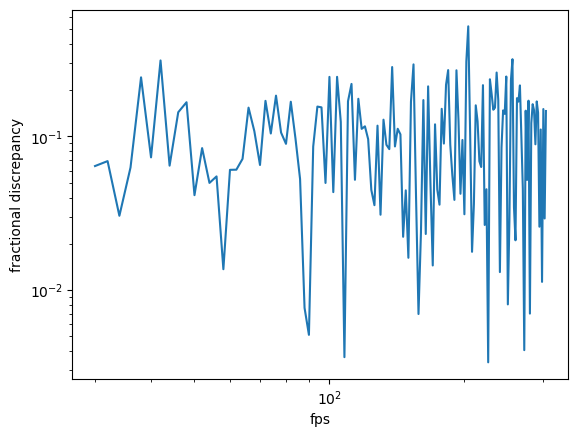

In [37]:
fig, ax = plt.subplots()
ax.plot(fps_arr, T_discrepancy_arr)
ax.set_xlabel('fps')
ax.set_ylabel('fractional discrepancy')
ax.set_xscale('log')
ax.set_yscale('log')

In [38]:
arr_discrep_average = np.zeros((len(spatial_resolution_arr), len(fps_arr)))
for k in range(0, 5):
    arr_discrep = np.zeros((len(spatial_resolution_arr), len(fps_arr)))
    for i in range(len(spatial_resolution_arr)):
        spatial_resolution_loop=spatial_resolution_arr[i]
        for j in range(len(fps_arr)):
            fps_loop=fps_arr[j]
            df=make_velocities(fps_loop,num_particles,spatial_resolution_loop,mu,T, right, up,2)
            discrepancy=get_percent_discrepancies(df[df['frame']==1]['vx (restored)'],df[df['frame']==1]['vx'])
            T_restored=mass*np.std(df[df['frame']==1]['vx (restored)'])**2/constants.Boltzmann
            arr_discrep[i,j]=np.abs(T-T_restored)/T
    arr_discrep_average = arr_discrep_average + arr_discrep / 5

In [39]:
for i in range(0, len(spatial_resolution_arr)):
    spatial_resolution_loop=spatial_resolution_arr[i]
    df=make_velocities(100,num_particles,spatial_resolution_loop,mu,T, right, up,2)
    df_i_ff = df[df['frame'] == 1]
    std_i = np.std(df_i_ff['vx (restored)'])
    tT = std_i**2 * mass / constants.Boltzmann
    arr_discrep[i] = np.abs((T -tT )) / T

Text(0, 0.5, 'discrepancy (%)')

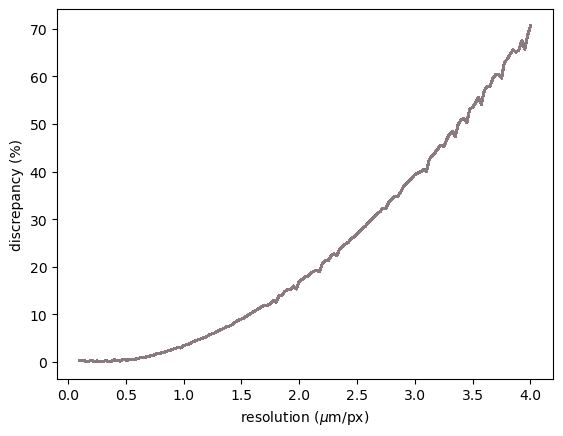

In [40]:
fig, ax = plt.subplots()
ax.plot(spatial_resolution_arr*100000, arr_discrep)
# ax.set_xscale('log')
ax.set_xlabel(r"resolution ($\mu$m/px)")
ax.set_ylabel("discrepancy (%)")

In [41]:
X, Y = np.meshgrid(fps_arr, spatial_resolution_arr* 1000000)

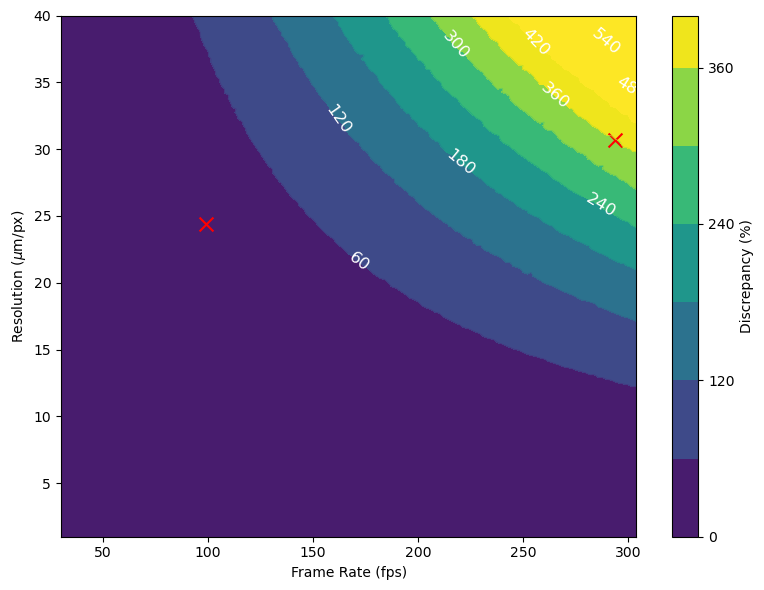

In [42]:
from matplotlib import colors
# Assuming X, Y, arr_discrep_average are already defined
fig4, ax4 = plt.subplots(figsize=(8, 6))

# Filled contours
khuj = ax4.contourf(X, Y, arr_discrep_average, levels=10, norm=colors.Normalize(vmin=0, vmax=400))

# Add colorbar with customized ticks
cbar = plt.colorbar(khuj, ax=ax4, label='Discrepancy (%)')

# Axis labels
ax4.set_ylabel(r"Resolution ($\mu$m/px)")
ax4.set_xlabel(r"Frame Rate (fps)")

# Experimental points
ax4.scatter([99, 294], [24.39, 30.69], marker='x', color='red', label='Experimental points', s=100)

# Set colorbar limits to enforce end at 400
cbar.ax.set_ylim(0, 400)

line_contours = ax4.contour(X, Y, arr_discrep_average, levels=khuj.levels, linewidths=0.5,norm=colors.Normalize(vmin=0, vmax=400))

ax4.clabel(
    line_contours,
    # khuj,
    fmt='%1.0f',
    fontsize=12,
    colors='white',
    inline=True,
    inline_spacing=2,
)
plt.savefig(f'Discrepancy_{TeV}eV.png', bbox_inches='tight')
plt.tight_layout()
plt.show()


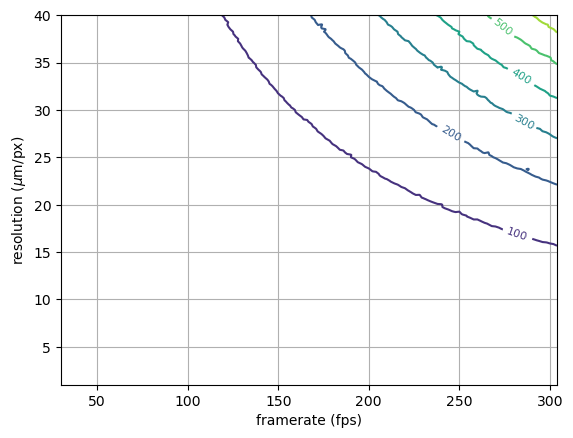

In [43]:
fig4, ax4 = plt.subplots()
khuj = ax4.contour(X, Y, arr_discrep_average)
ax4.set_ylabel(r"resolution ($\mu$m/px)")
ax4.set_xlabel(r"framerate (fps)")
ax4.clabel(khuj,
          inline=True,       # draw labels on the contour lines
          fmt='%1.0f',       # format string for the level numbers
          fontsize=8)
ax4.grid(True)
# ax4.set_ylim(9, 30)